In [1]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c aptos2019-blindness-detection

100% 8.00G/8.01G [01:02<00:00, 156MB/s]
100% 8.01G/8.01G [01:02<00:00, 138MB/s]
100% 1.50G/1.50G [00:12<00:00, 135MB/s]
100% 1.50G/1.50G [00:12<00:00, 127MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 50.9MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 25.4MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 29.7MB/s]


In [4]:
!unzip "train_images.zip" -d "train"
!unzip "test_images.zip" -d "test"

Archive:  train_images.zip
  inflating: train/7b9d519cbd66.png  
  inflating: train/ae49cc60f251.png  
  inflating: train/b294927b14b0.png  
  inflating: train/f4d3777f2710.png  
  inflating: train/d74ccc796517.png  
  inflating: train/15bed5adde74.png  
  inflating: train/f002ce614c59.png  
  inflating: train/7335a2d43ada.png  
  inflating: train/9b7b6e4db1d5.png  
  inflating: train/1968183f0e61.png  
  inflating: train/d91273efb92a.png  
  inflating: train/5cf9127f251a.png  
  inflating: train/370f575adb23.png  
  inflating: train/4c17e85686f0.png  
  inflating: train/4f7755e74a9e.png  
  inflating: train/25e9fd872182.png  
  inflating: train/b64e1eef3d63.png  
  inflating: train/e7d2c2c3b30f.png  
  inflating: train/bfda2fd0533a.png  
  inflating: train/224bb938e2dd.png  
  inflating: train/d51e5d7484ea.png  
  inflating: train/dc6fa1b38b83.png  
  inflating: train/74898f372d2b.png  
  inflating: train/152db3de8120.png  
  inflating: train/07929d32b5b3.png  
  inflating: train/0773

In [0]:
#Imports
import fastai
import numpy as np 
import pandas as pd
import os, sys
from fastai import *
from fastai.vision import *

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(7)

In [0]:
PATH = Path('')
df_train = pd.read_csv(PATH/"train.csv") \
           .assign(filename = lambda df: "train/" + df.id_code + ".png")
df_test = pd.read_csv(PATH/"test.csv") \
          .assign(filename = lambda df: "test/" + df.id_code + ".png")

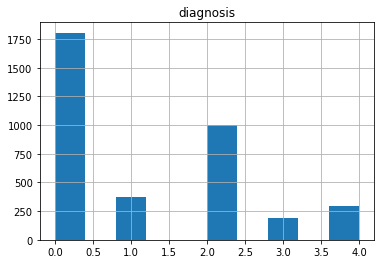

In [8]:
_ = df_train.hist()

In [9]:
df_train.head()

,id_code,diagnosis,filename
0,000c1434d8d7,2,train/000c1434d8d7.png
1,001639a390f0,4,train/001639a390f0.png
2,0024cdab0c1e,1,train/0024cdab0c1e.png
3,002c21358ce6,0,train/002c21358ce6.png
4,005b95c28852,0,train/005b95c28852.png


In [0]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1,
    max_rotate = 180, 
    max_lighting = 0.9, 
    max_warp = 0.1 
)

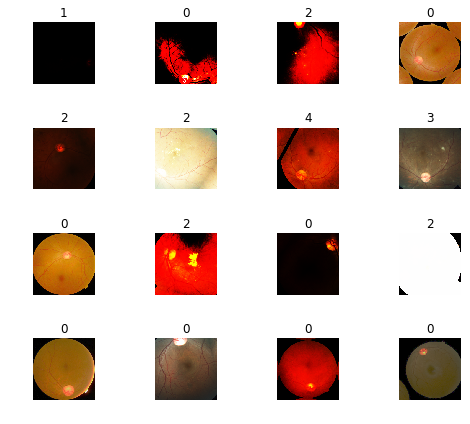

In [11]:
data = ImageDataBunch.from_df(path = "",
                              df = df_train,
                              fn_col = "filename",
                              label_col = "diagnosis",
                              ds_tfms = transforms,
                             size=224)\
        .normalize(imagenet_stats)

data.show_batch(rows=4, figsize=(7,6))

In [12]:
kappa = KappaScore()
kappa.weights = "quadratic"
learn = cnn_learner(data, models.resnet50,
                    metrics=[error_rate, kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 16435389.08it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.42E-03
Min loss divided by 10: 1.07E-02


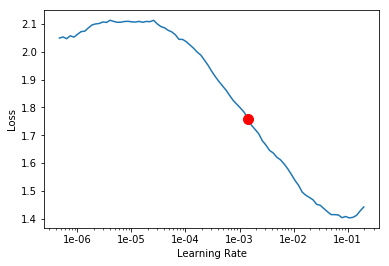

In [13]:
learn.lr_find(end_lr=0.5)
learn.recorder.plot(suggestion=True)

In [15]:
lr = 7e-3
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,1.252922,0.834947,0.319672,0.742916,07:52
1,0.966501,0.605931,0.226776,0.851010,07:58
2,0.840635,0.585453,0.218579,0.804544,08:03
3,0.750147,0.495802,0.199454,0.847963,07:59
4,0.716597,0.531956,0.202186,0.828444,07:58
5,0.684919,0.488238,0.185792,0.869261,08:05
6,0.635661,0.451416,0.177596,0.883700,08:03
7,0.607625,0.458826,0.166667,0.882004,08:05
8,0.589731,0.451876,0.181694,0.872690,08:07
9,0.567109,0.450019,0.183060,0.868994,08:04


In [0]:
print('foo, barf tech')
print ('done maybe')   

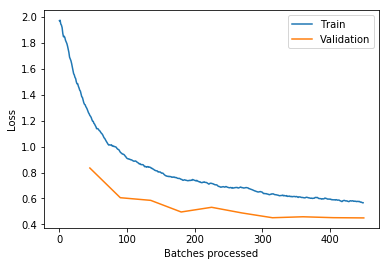

In [16]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.577649,0.460133,0.176230,0.877497,07:59
1,0.595457,0.468179,0.176230,0.873645,07:48
2,0.603705,0.473259,0.196721,0.873943,07:51
3,0.590006,0.501788,0.180328,0.907696,07:49
4,0.578006,0.455614,0.157104,0.893588,07:52
5,0.561803,0.453428,0.161202,0.900954,07:55
6,0.528145,0.495013,0.168033,0.882809,07:45
7,0.518653,0.440888,0.165301,0.891931,07:46
8,0.490513,0.435501,0.157104,0.898801,07:43
9,0.490426,0.433976,0.153005,0.901947,07:45


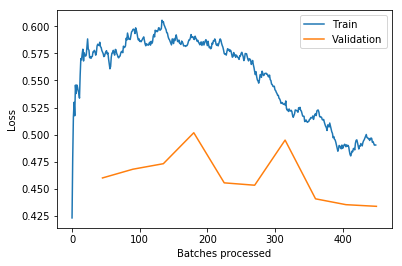

In [17]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(10,lrs)

learn.recorder.plot_losses()

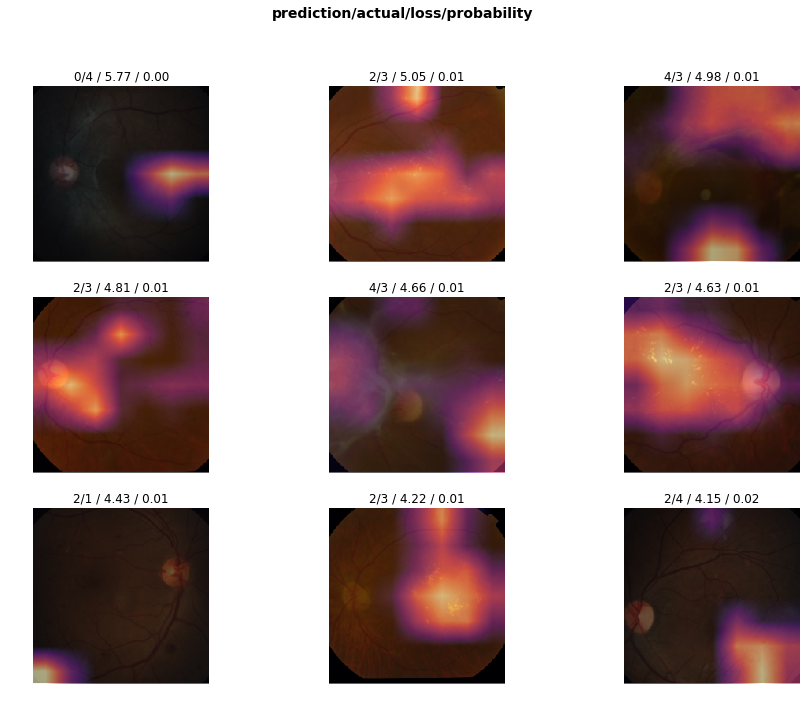

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11)) #can add heatmap=True for graadcam

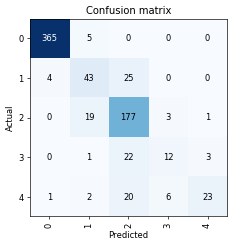

In [22]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [0]:
learn.export('trained_model50.pkl')


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp "trained_model50.pkl" "/content/drive/My Drive/atops_trained.pkl"